<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Applied Probability Theory From Scratch</h1>
        <h1>Random Walks</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

import watermark

%load_ext watermark
%matplotlib inline

In [2]:
%watermark -n -v -m -g -iv

seaborn    0.10.0
json       2.0.9
numpy      1.18.1
watermark  2.0.2
autopep8   1.5
matplotlib 3.1.3
Fri Aug 21 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 3029db88538474325720d5f3ece806f74c8330eb


Set the default style

In [3]:
plt.style.use('./d4sci.mplstyle')

## Unbiased Random Walks

Let's start by redefining our coin flip function

In [4]:
def flip_coin(n_coins, n_times, p=0.5):
    return 2*(np.random.random((n_times, n_coins))<p)-1

We can roll 3 independent coins 1000 times

In [5]:
steps = flip_coin(3, 1000)

If for each head we take a step up and for each tails we take as step down, our paths will be

In [6]:
position = steps.cumsum(axis=0)

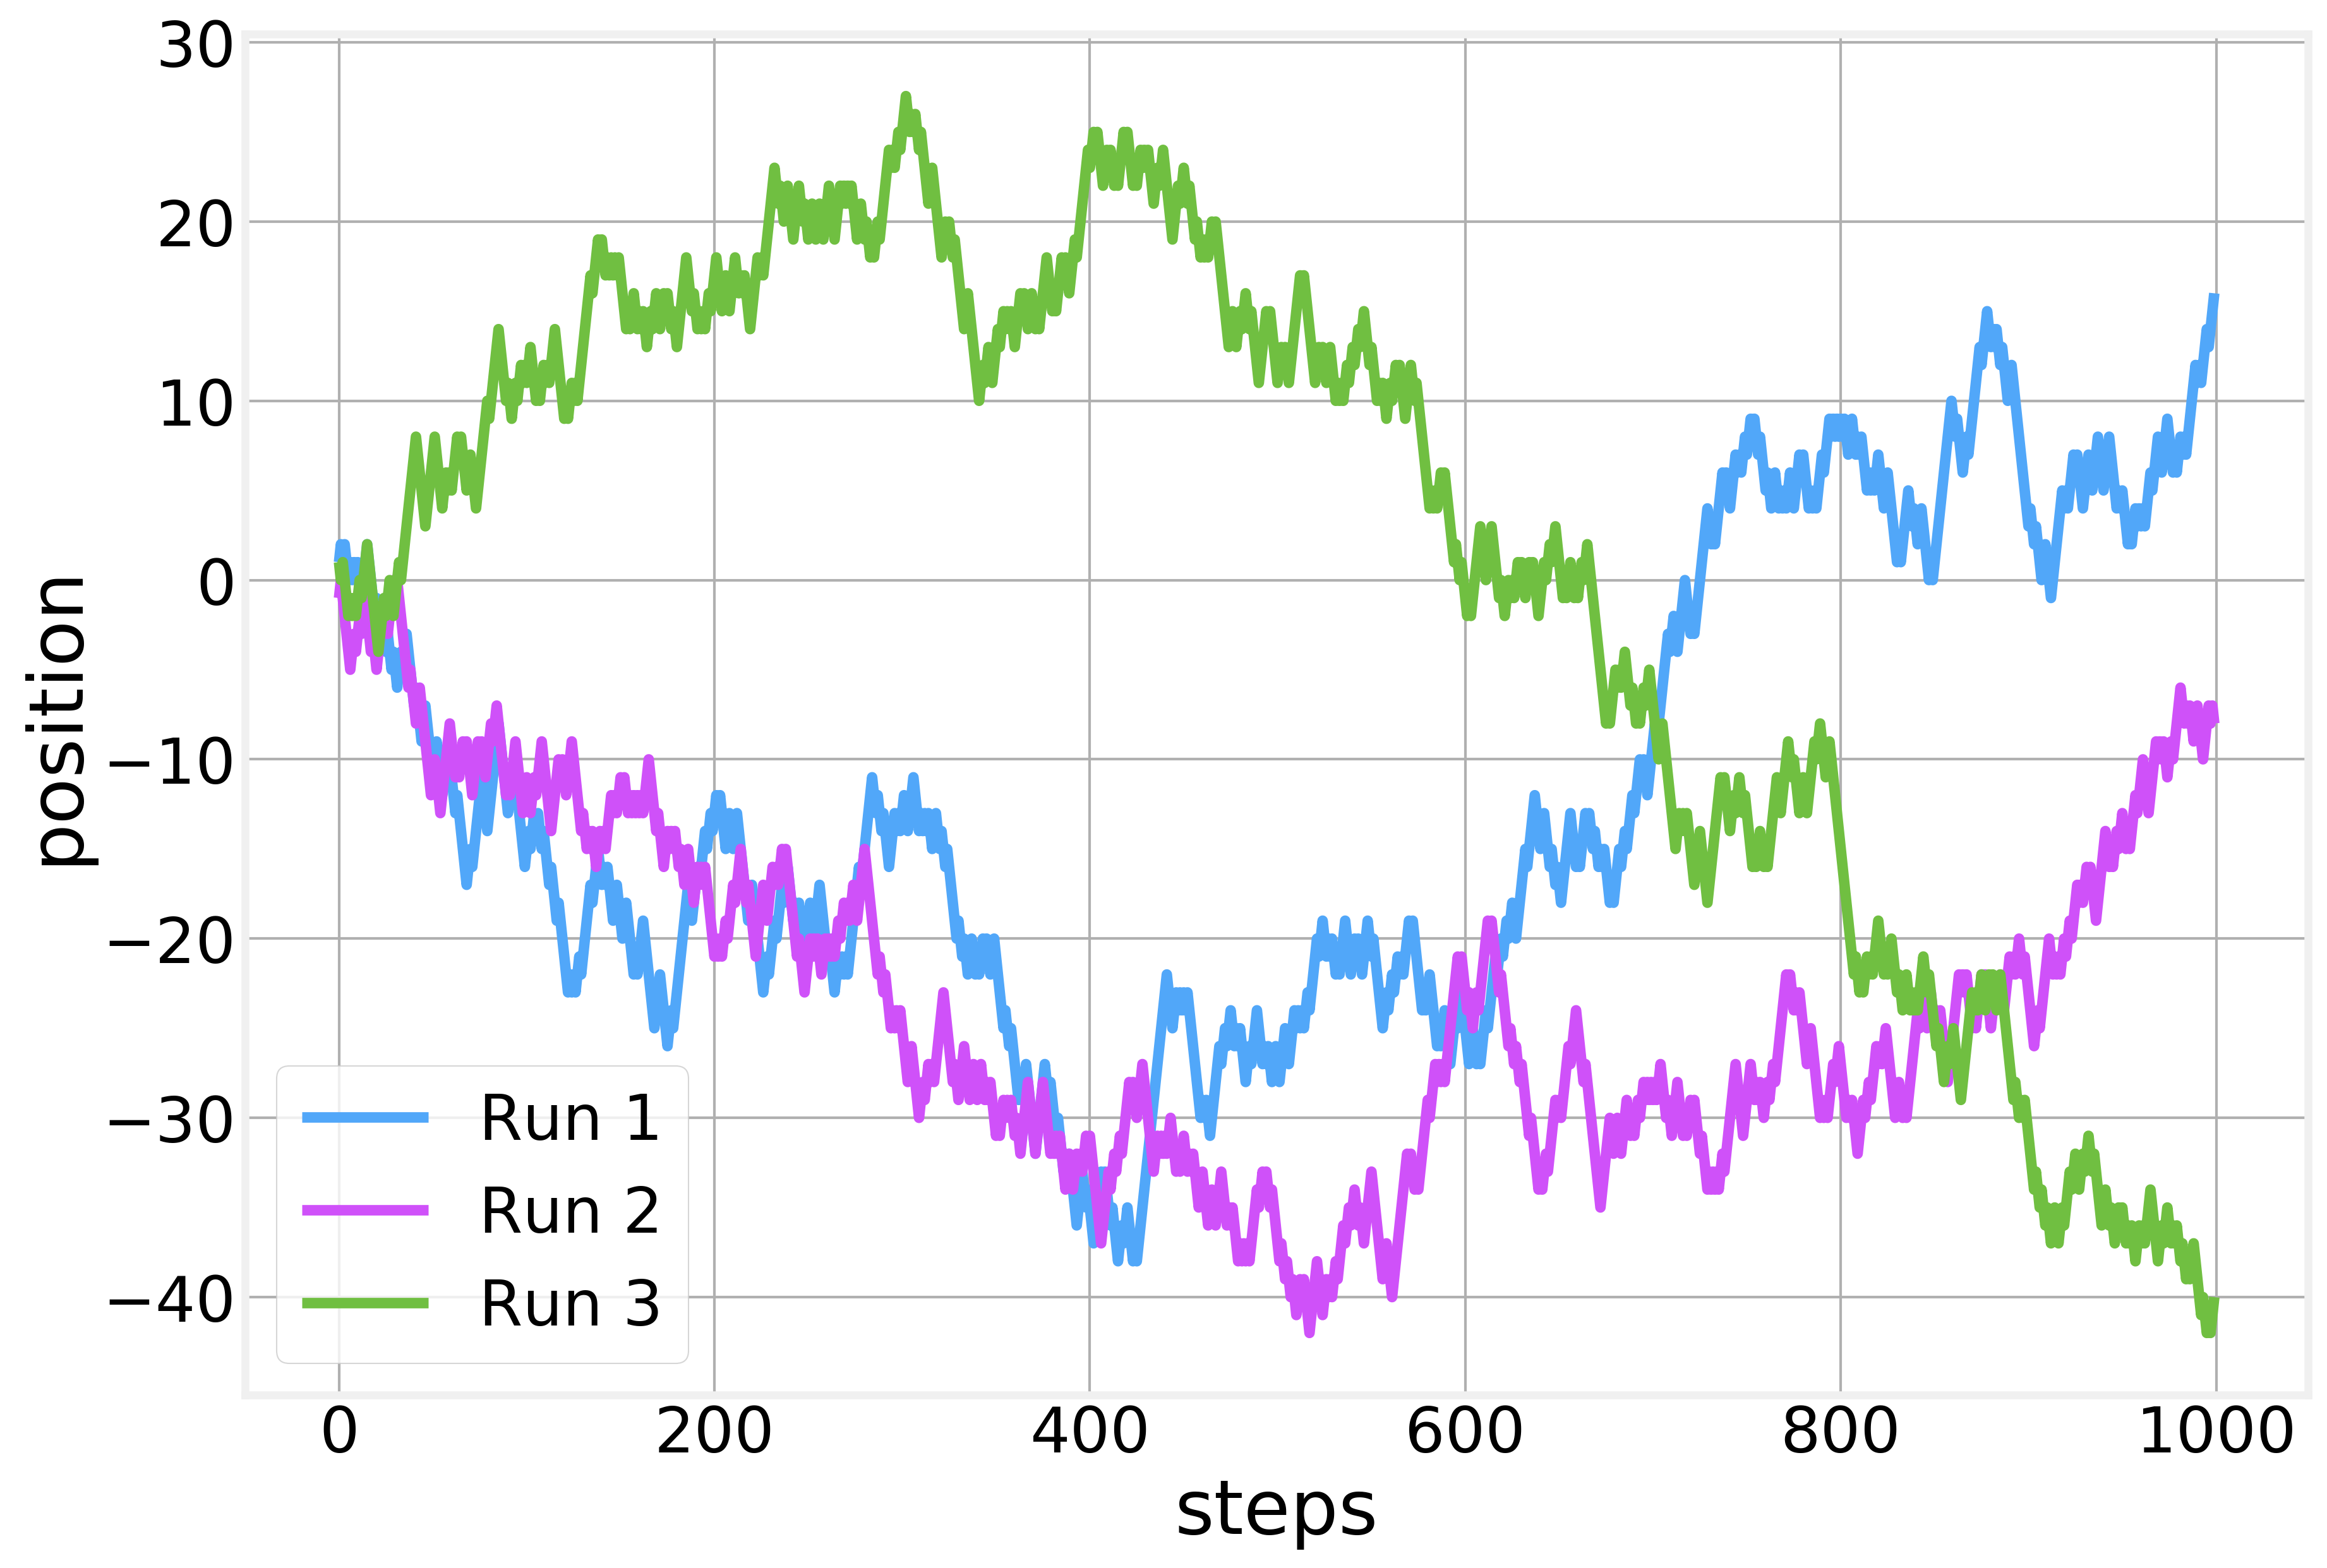

In [7]:
plt.plot(np.arange(1000), position.T[0], label='Run 1')
plt.plot(np.arange(1000), position.T[1], label='Run 2')
plt.plot(np.arange(1000), position.T[2], label='Run 3')
plt.xlabel('steps')
plt.ylabel('position')
plt.legend()

Let us also bring back our pmf function from before

In [8]:
def pmf(values, normed=False):
    counts = Counter(values.flatten())
    output = np.array(sorted(counts.items(), key=lambda x:x[0]), dtype='float')
    
    if normed:
        norm = output.T[1].sum()
        output.T[1] = output.T[1]/norm
    
    return output

In [9]:
pmf1 = pmf(position.T[0])
pmf2 = pmf(position.T[1])
pmf3 = pmf(position.T[2])

So we obtain the total histogram of visits across all three runs

In [10]:
total = pmf(position.flatten()) 

And finally we plot all four distributions together

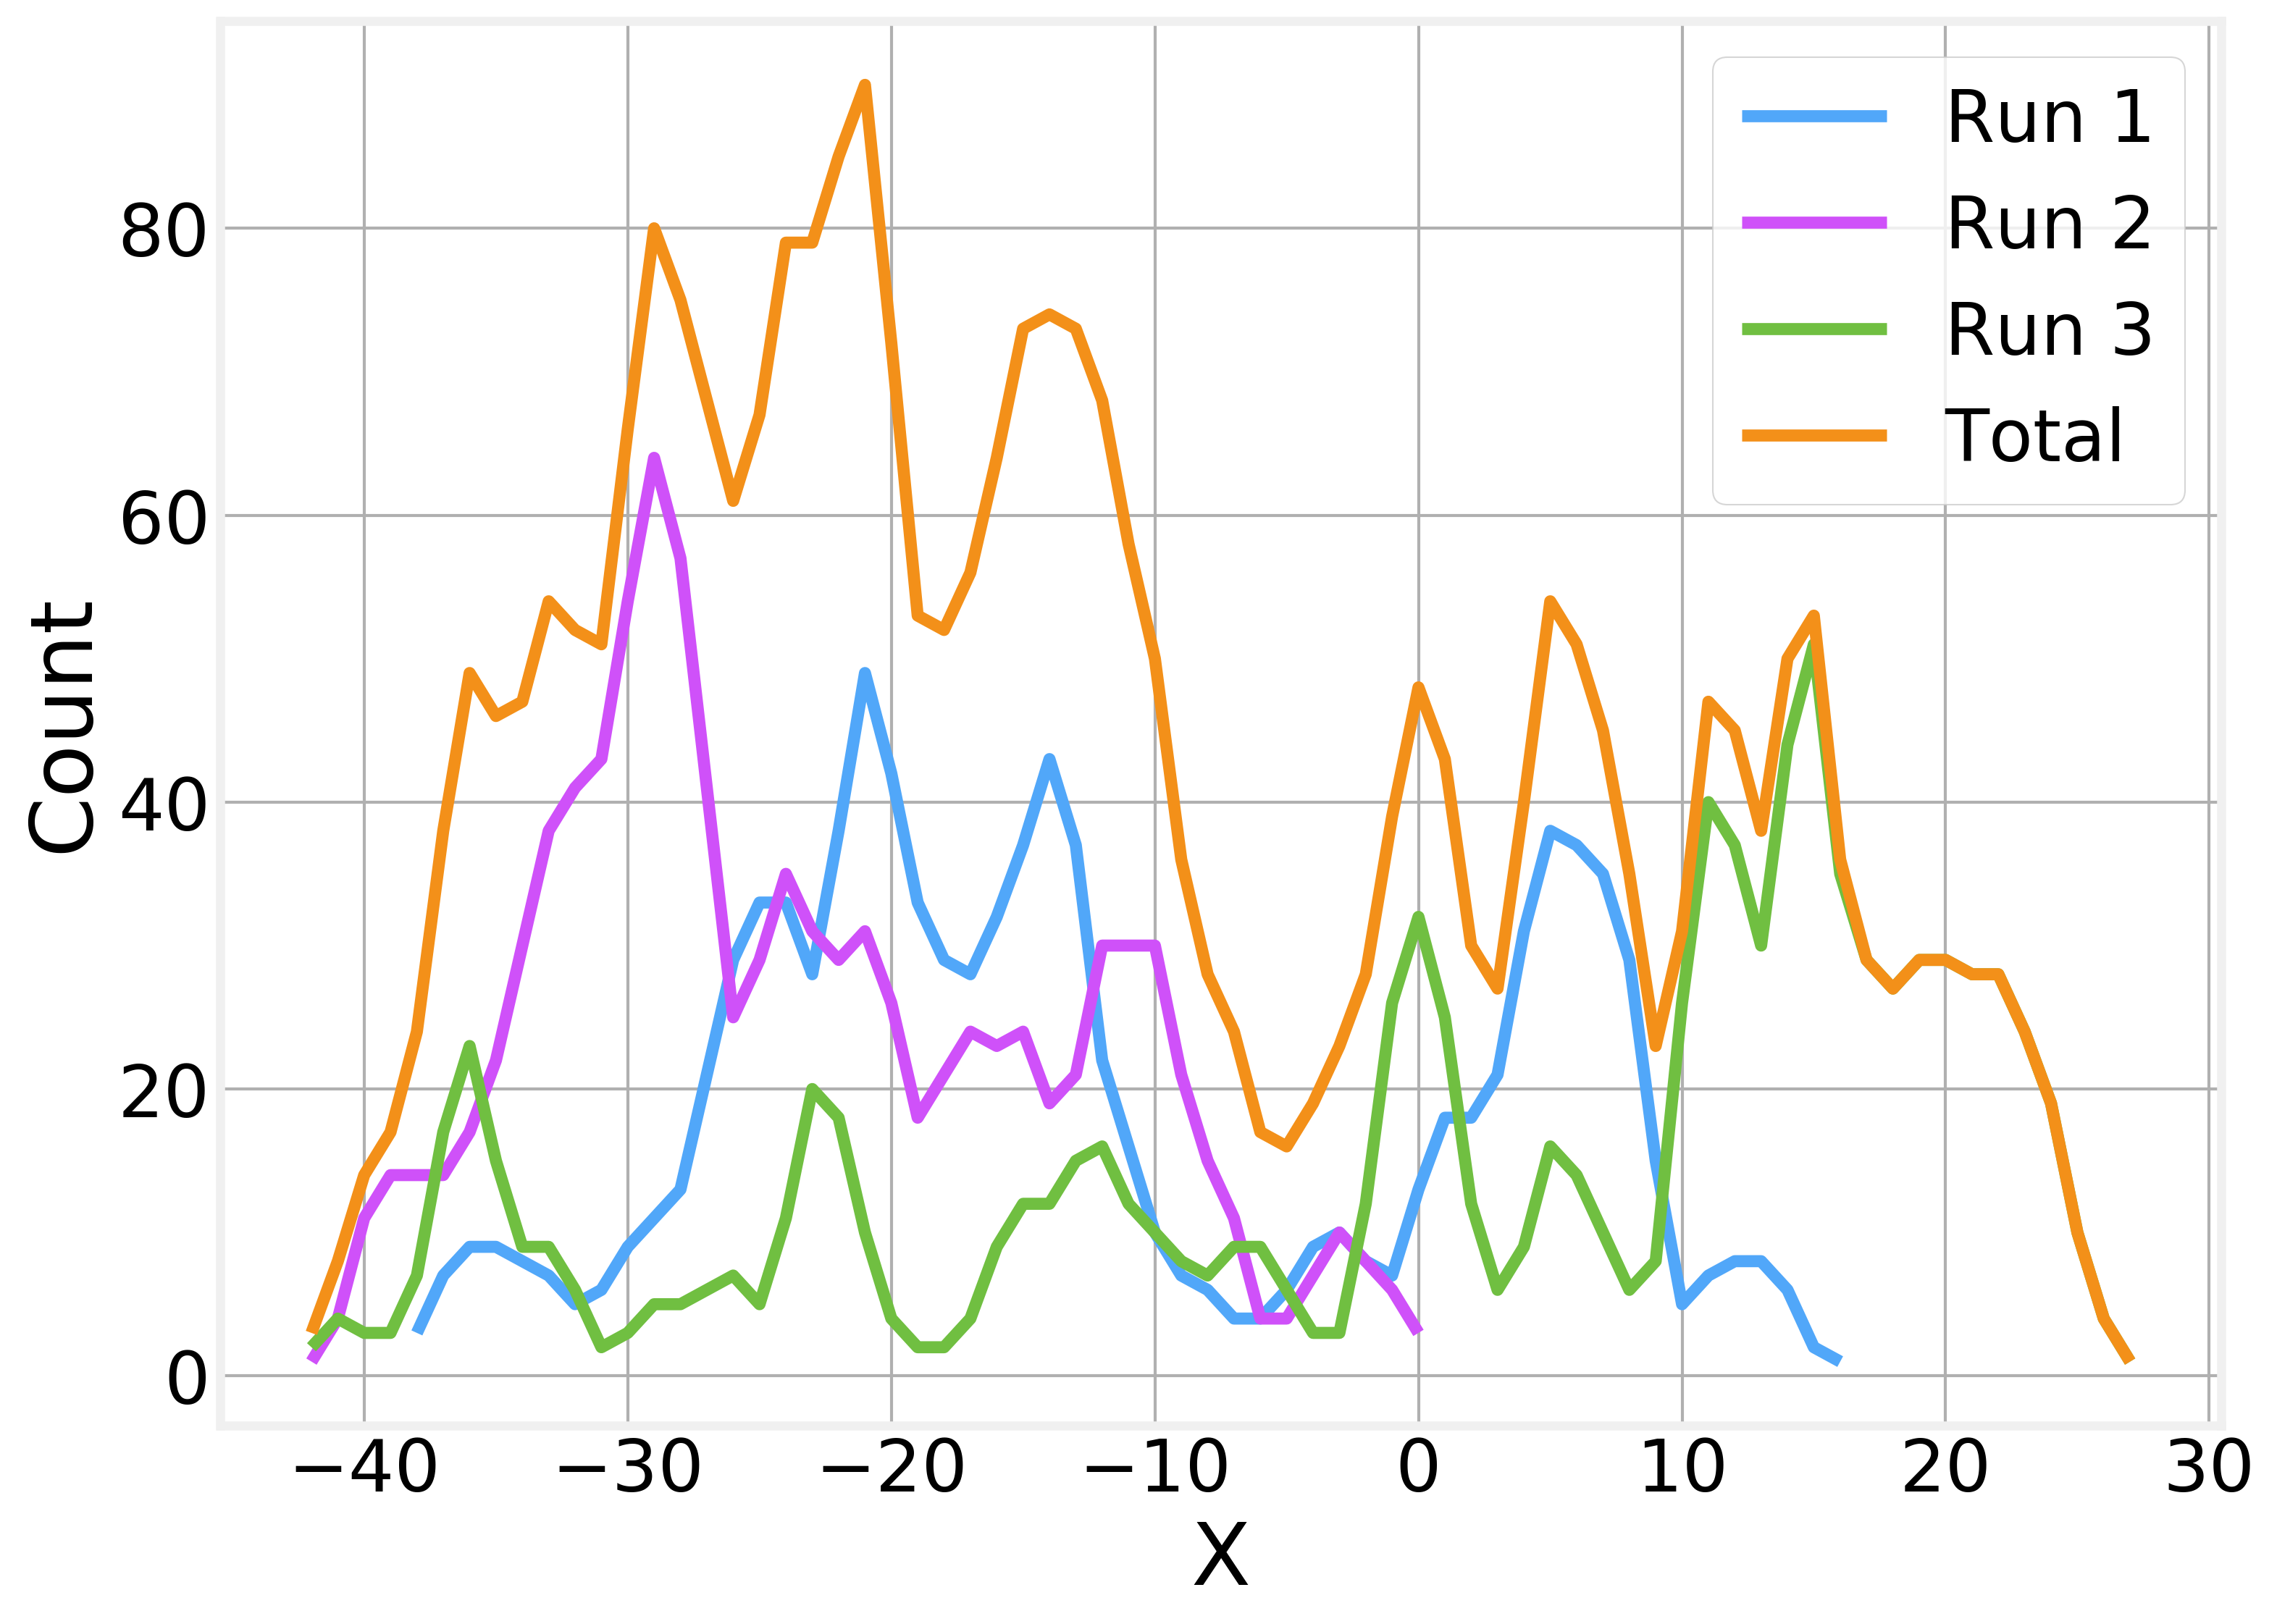

In [11]:
plt.plot(pmf1.T[0],pmf1.T[1], label='Run 1')
plt.plot(pmf2.T[0],pmf2.T[1], label='Run 2')
plt.plot(pmf3.T[0],pmf3.T[1], label='Run 3')
plt.plot(total.T[0],total.T[1], label='Total')
plt.xlabel('X')
plt.ylabel('Count')
plt.legend()
plt.gcf().set_size_inches(11, 8)

## Biased Random walks

If the coin is unfair we will have a drift in one direction or the other

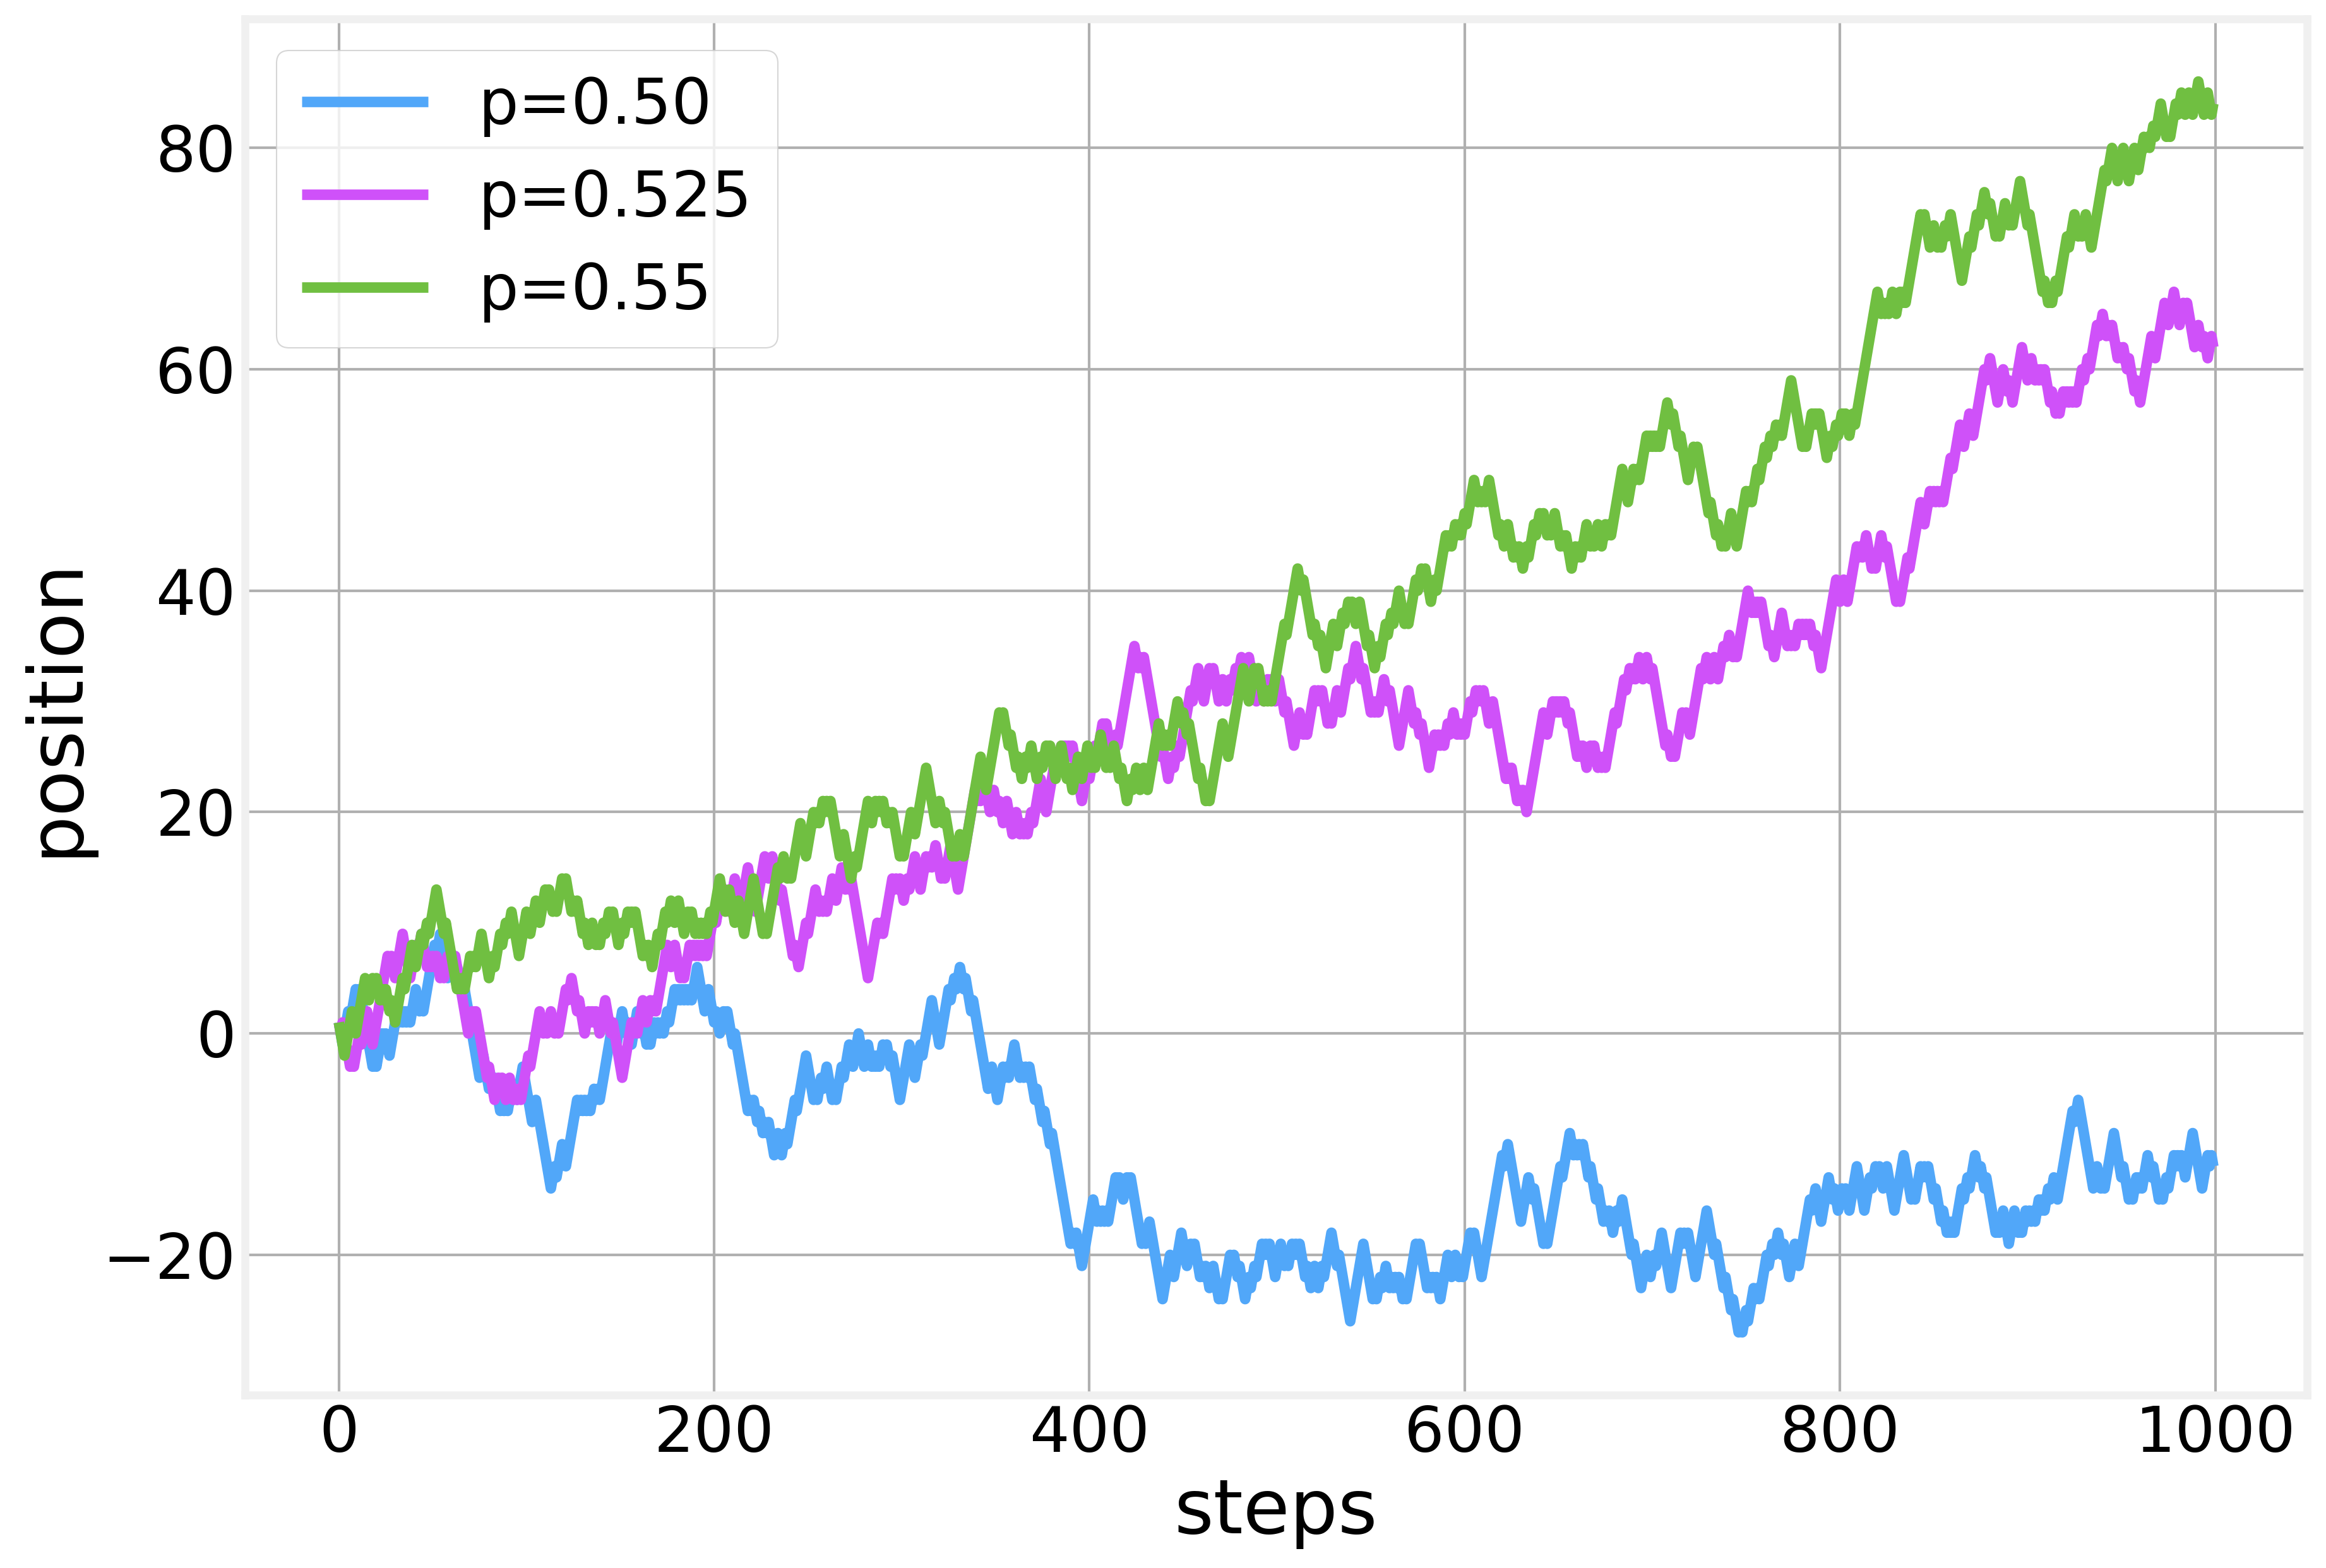

In [12]:
plt.plot(np.arange(1000), flip_coin(1, 1000, 0.5).cumsum(), label='p=0.50')
plt.plot(np.arange(1000), flip_coin(1, 1000, 0.525).cumsum(), label='p=0.525')
plt.plot(np.arange(1000), flip_coin(1, 1000, 0.55).cumsum(), label='p=0.55')
plt.xlabel('steps')
plt.ylabel('position')
plt.legend()

Naturally, the more unfair the coin, the more biased the walk. In 2 (or more) dimensions the situation is similar, the only difference being that we must chose among more possible moves using more coins

Text(0, 0.5, 'y')

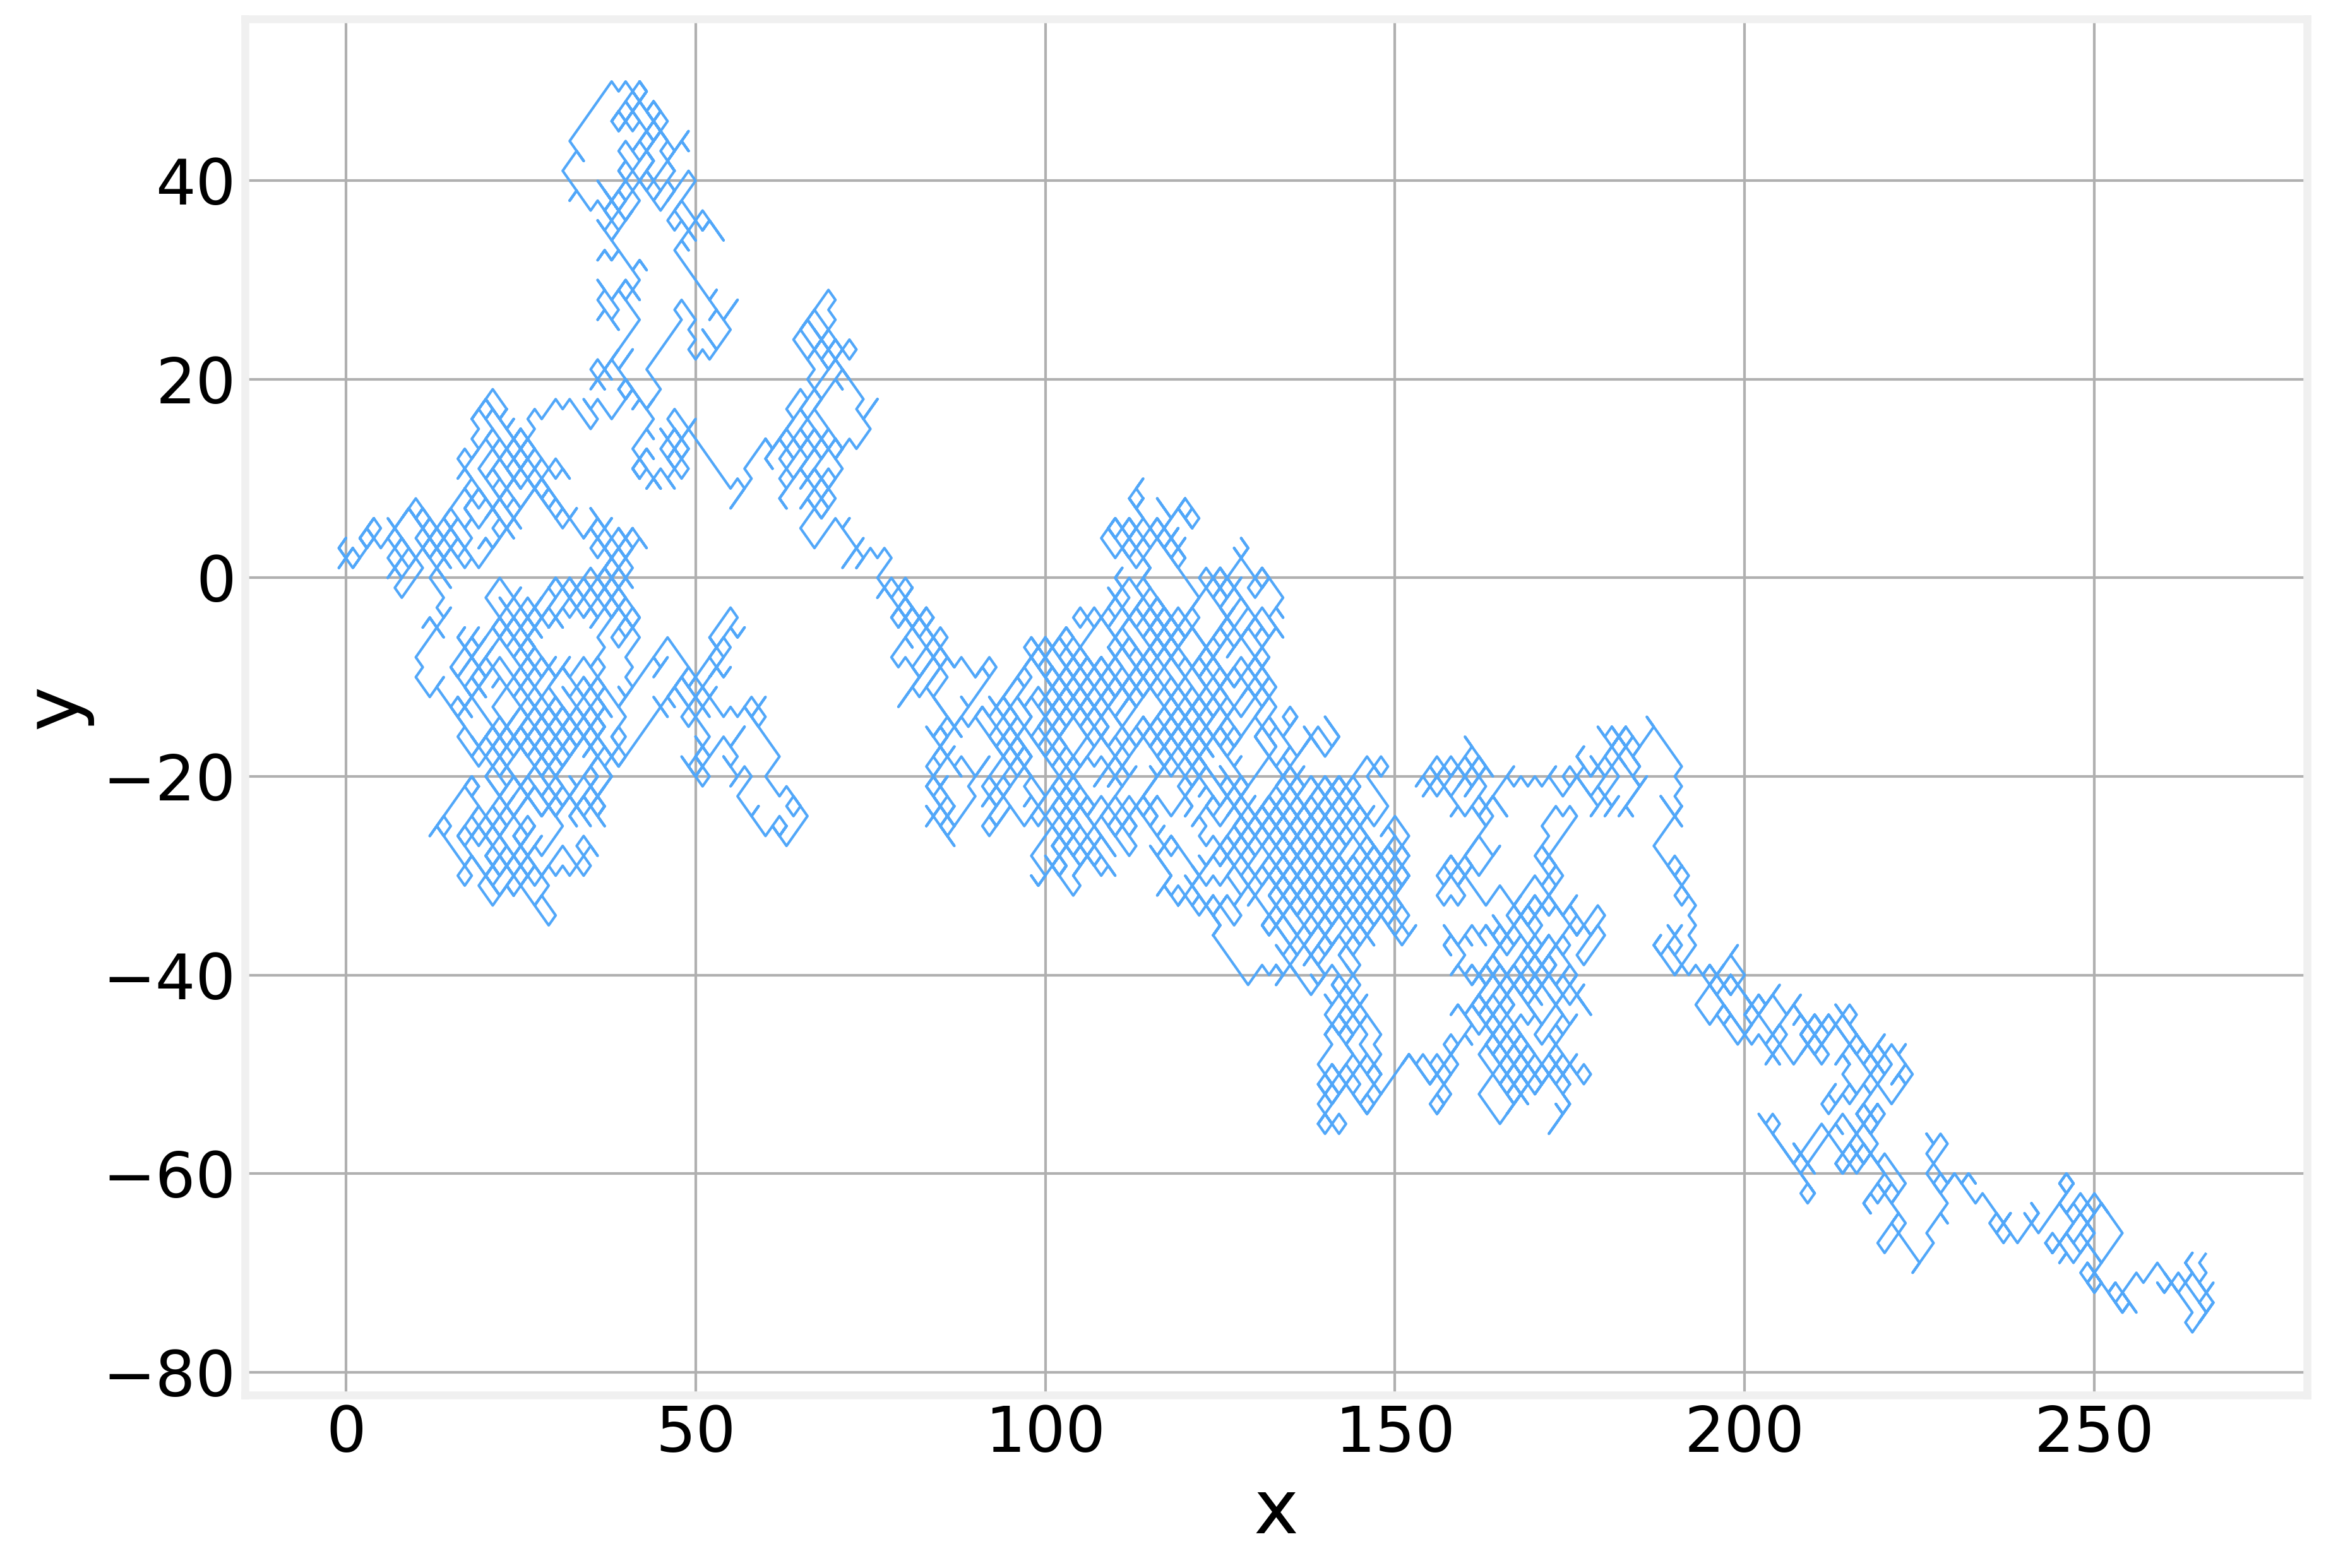

In [13]:
position2D = flip_coin(2, 10000).cumsum(axis=0)
plt.plot(position2D.T[0], position2D.T[1], lw=1)
plt.xlabel('x')
plt.ylabel('y')

## Levy flights

The 1 and 2 dimensional examples we considered here are just the simplest examples. Random Walks are a large and fascinating world with many applications and variations. Perhaps one of the most interesting ones are Levy flights where the steps can take any direction and be of varying length as well.

In [14]:
def levyFlight(Nsteps):
    R = np.random.pareto(2, Nsteps)
    theta = 2*np.pi*np.random.random(Nsteps)
    
    x = (R*np.cos(theta)).cumsum()
    y = (R*np.sin(theta)).cumsum()
    
    return [x, y]

Where we are choosing uniformly the direction of movement and the distance from a broad tailed distribution, resulting in occasionally extremely large jumps as observed in the foraging behavior of certain animals

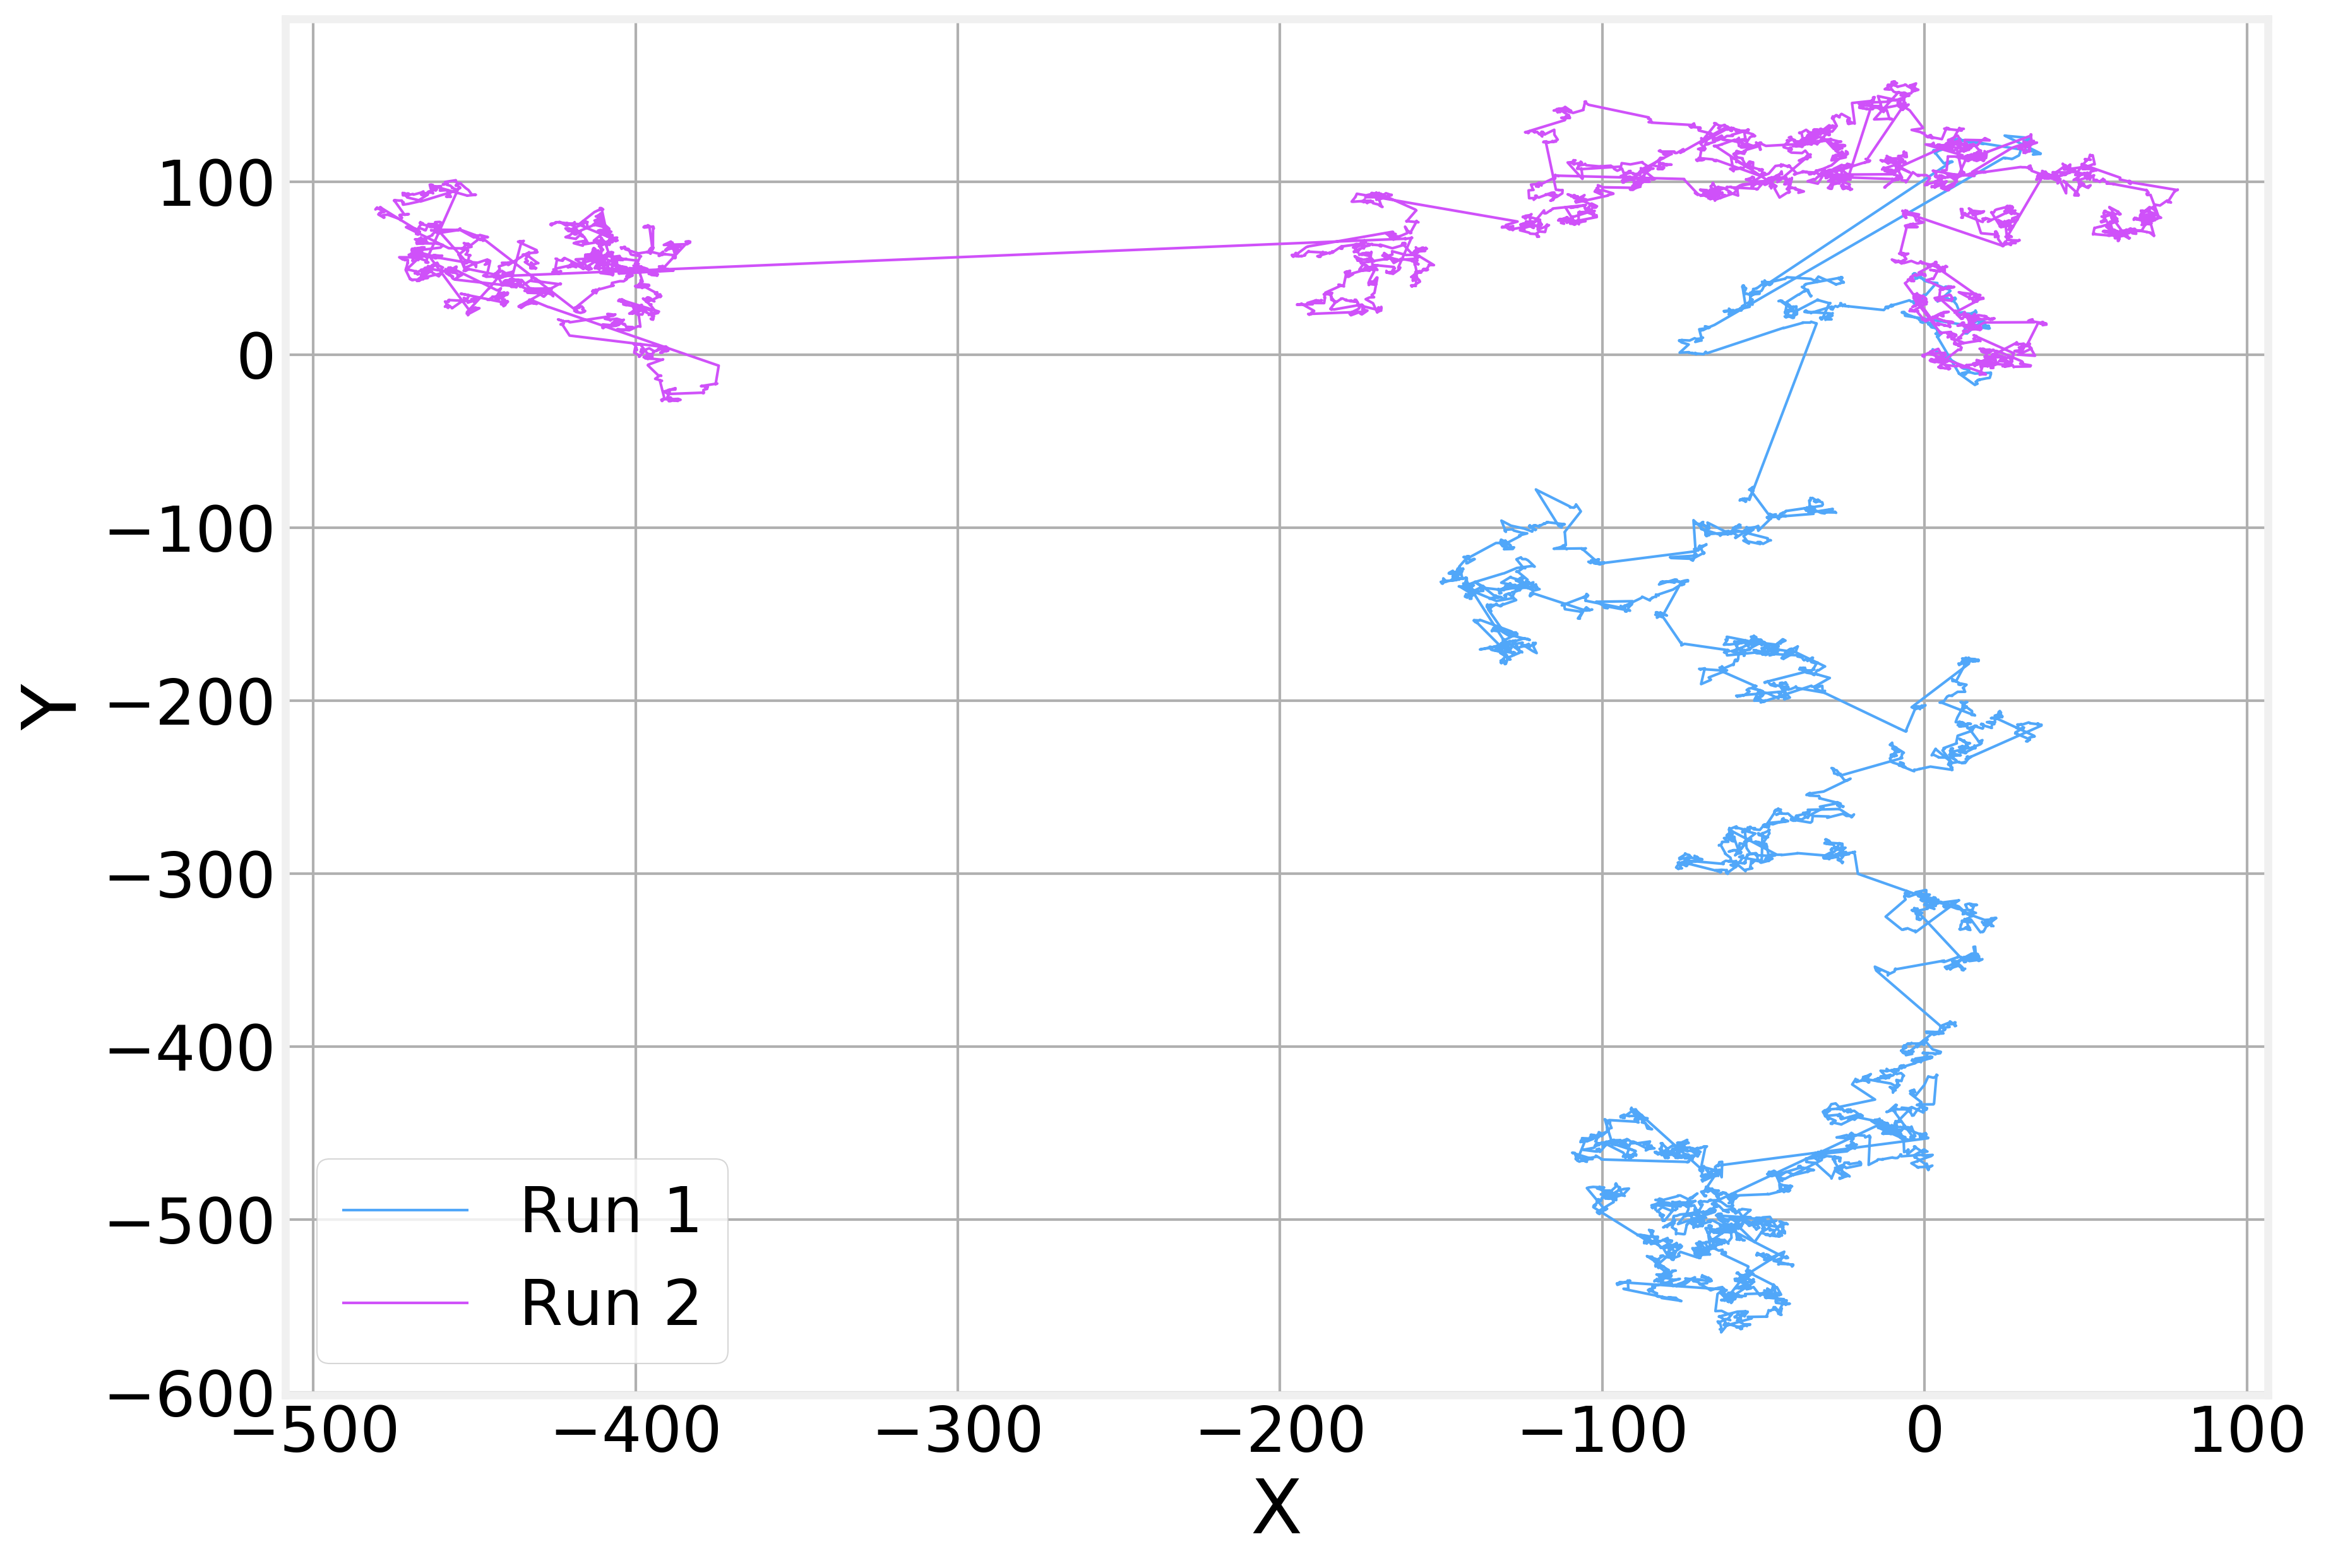

In [15]:
lfx1, lfy1 = levyFlight(10000)
lfx2, lfy2 = levyFlight(10000)

plt.plot(lfx1, lfy1, label='Run 1', lw=1)
plt.plot(lfx2, lfy2, label='Run 2', lw=1)

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

## PageRank

One particularly interesting application of random walks is in PageRank, the algorithm underlying the Google search engine. Here we apply it to the celegans network of 297 neurons

In [16]:
N = 297
A = np.zeros((N, N))

We read the network structure directly from a file and initialize the adjacency matrix, where every element is zero except in the elements corresponding to existing connections

In [17]:
for line in open("data/celegans.txt"):
    node_i, node_j = line.strip().split()

    node_i = int(node_i)
    node_j = int(node_j)

    A[node_i, node_j] = 1

The number of connections for each node can be obtained by summing the number of non-zero elements

In [18]:
K_i = A.sum(axis=0)

And the degree distribution is

In [19]:
Pk = pmf(K_i)

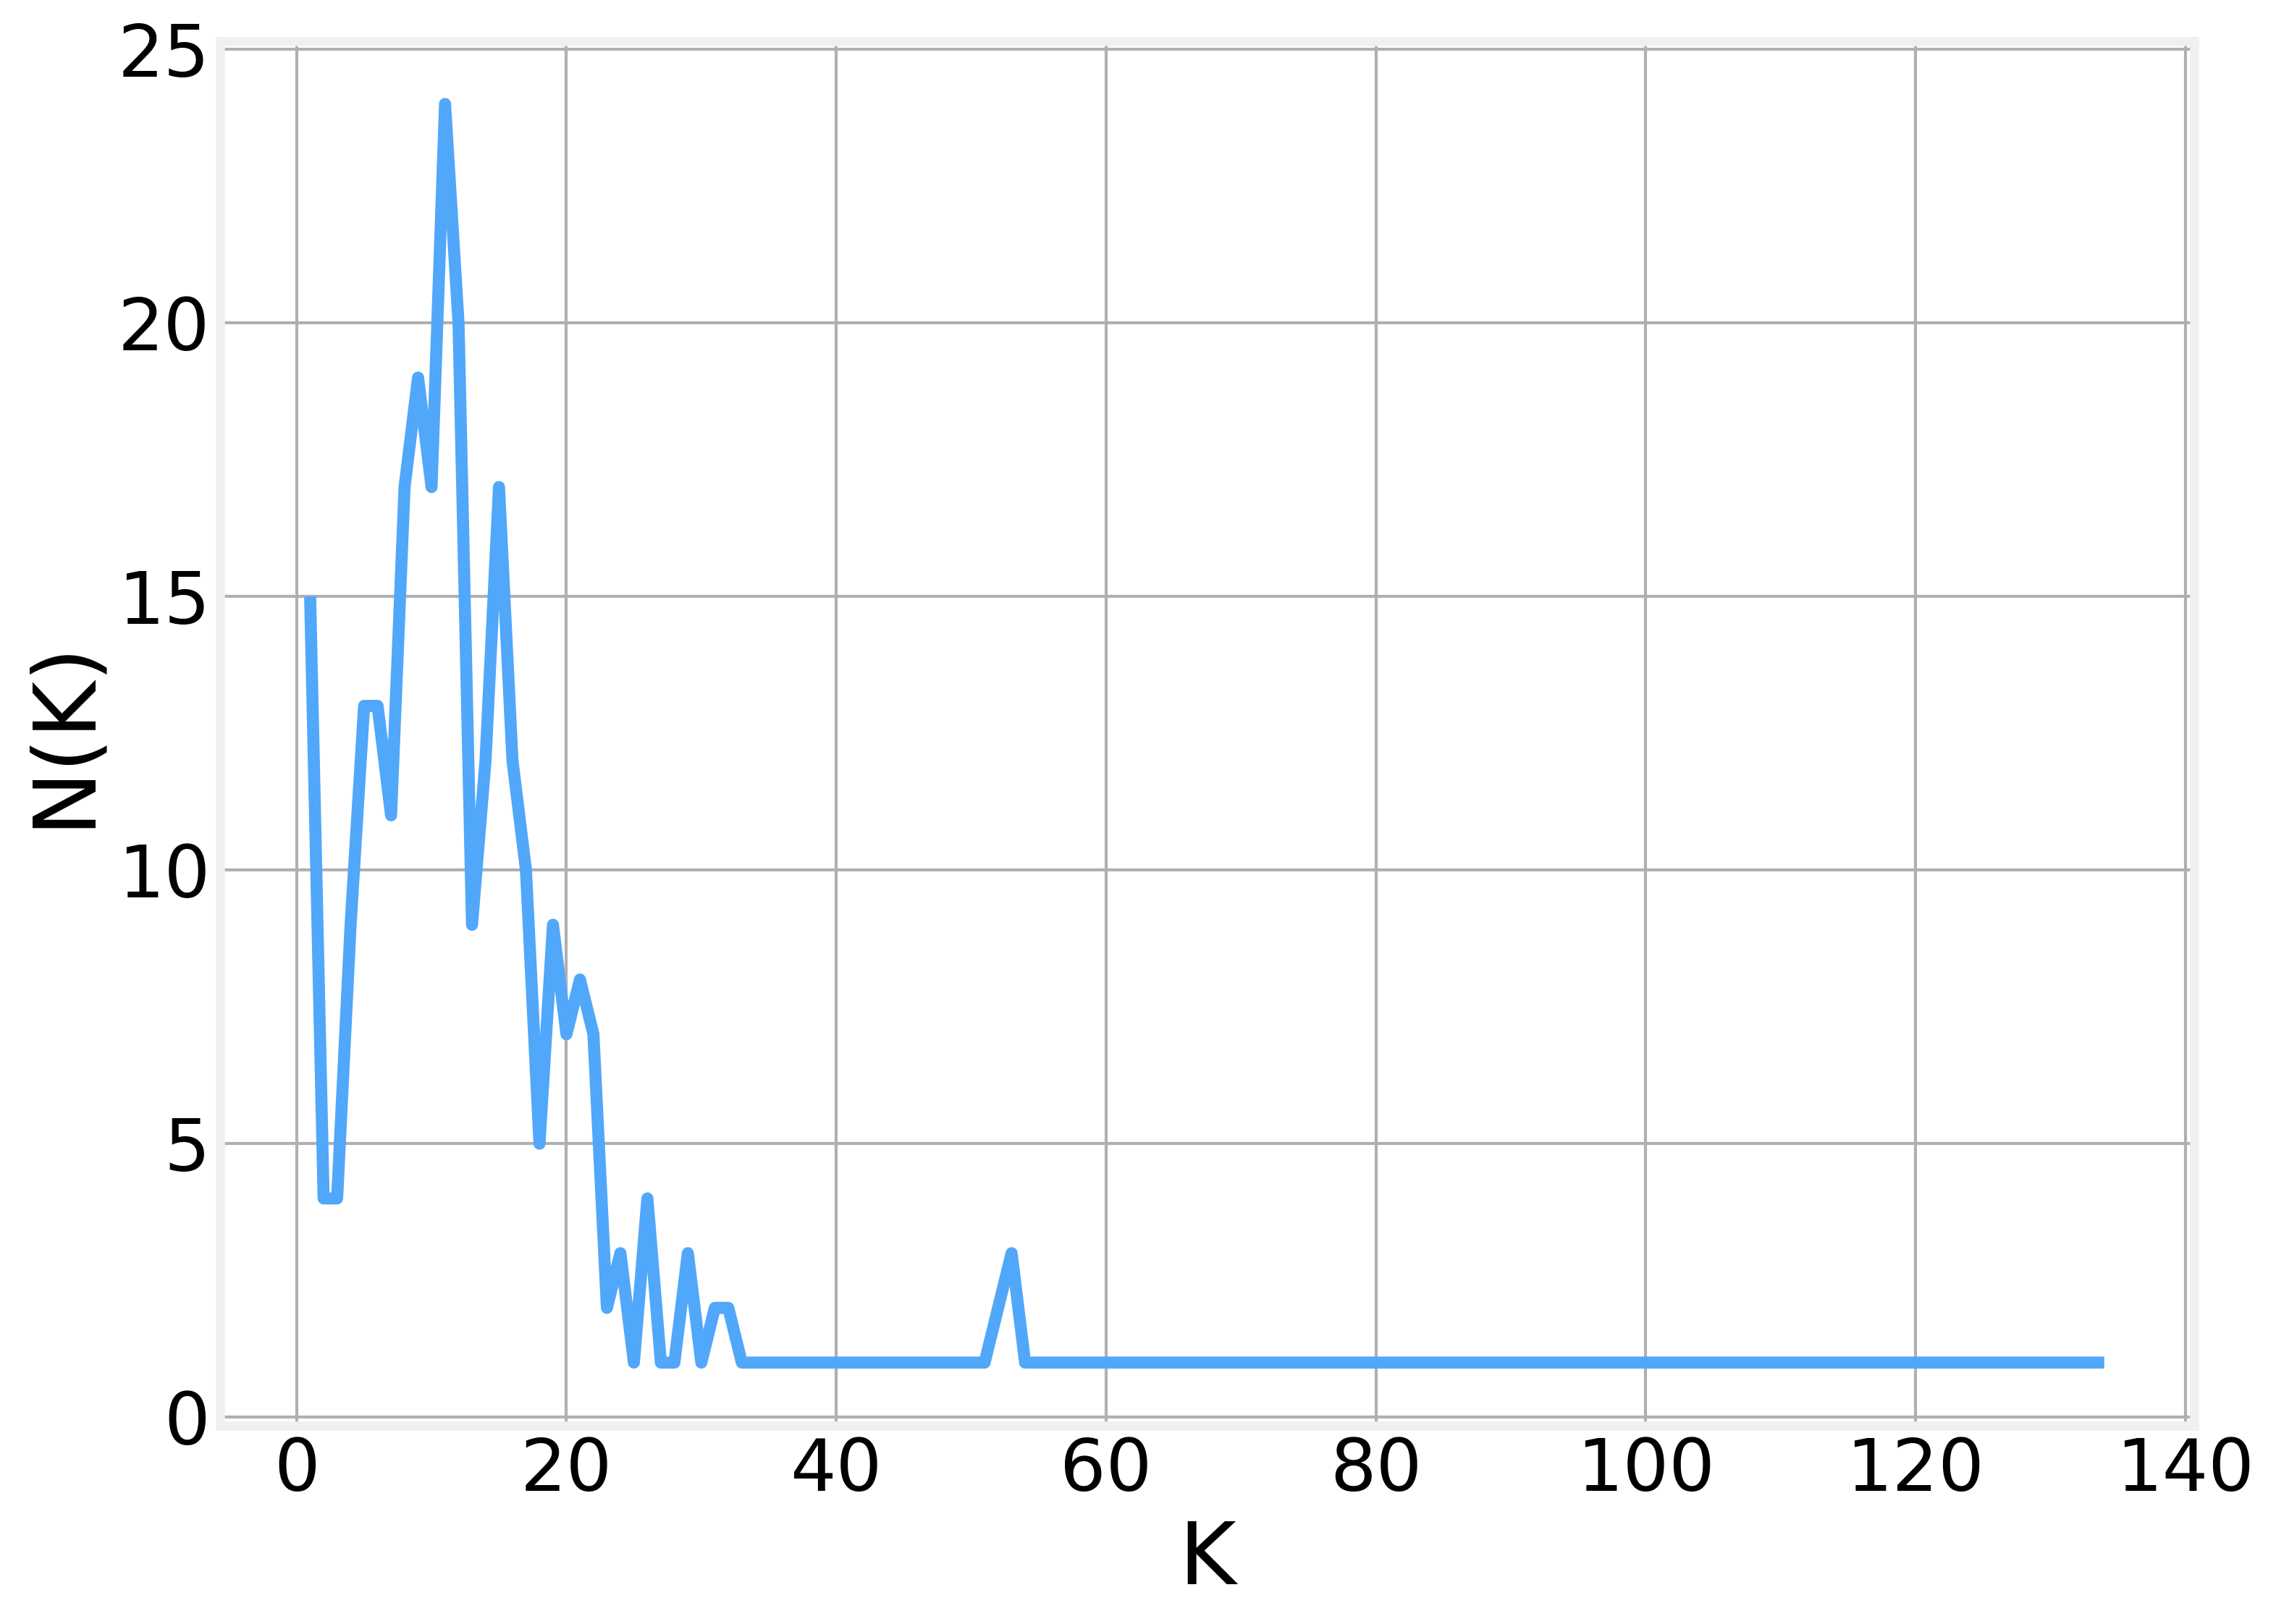

In [20]:
plt.plot(Pk.T[0], Pk.T[1])
plt.xlabel('K')
plt.ylabel('N(K)')
plt.gcf().set_size_inches(11, 8)

So we can see that most nodes have degrees below 20 while a few can have degrees as high as 134.

The Google Matrix is defined from the Adjacenty matrix by adding the atenuation factor and removing dangling nodes

In [21]:
def Google_Matrix(A, m):
    N = A.shape[0]
    v = np.ones(N)

    KT = np.dot(A.T, v)

    for i in range(N):
        A.T[i] = A.T[i]/KT[i]

    S = np.ones((N, N))/N
    G = (1-m)*A+m*S

    return G

Finally, we define a function to implement the power method

In [22]:
def Power_Method(G, iter):
    N = G.shape[0]
    x0 = np.ones(N)/N

    for i in range(iter):
        x0 = np.dot(G, x0)

    return x0

And finally

In [23]:
G = Google_Matrix(A, 0.15)
x0 = Power_Method(G, 1000)

we can plot the PageRank value of each node

Text(0, 0.5, 'PageRank')

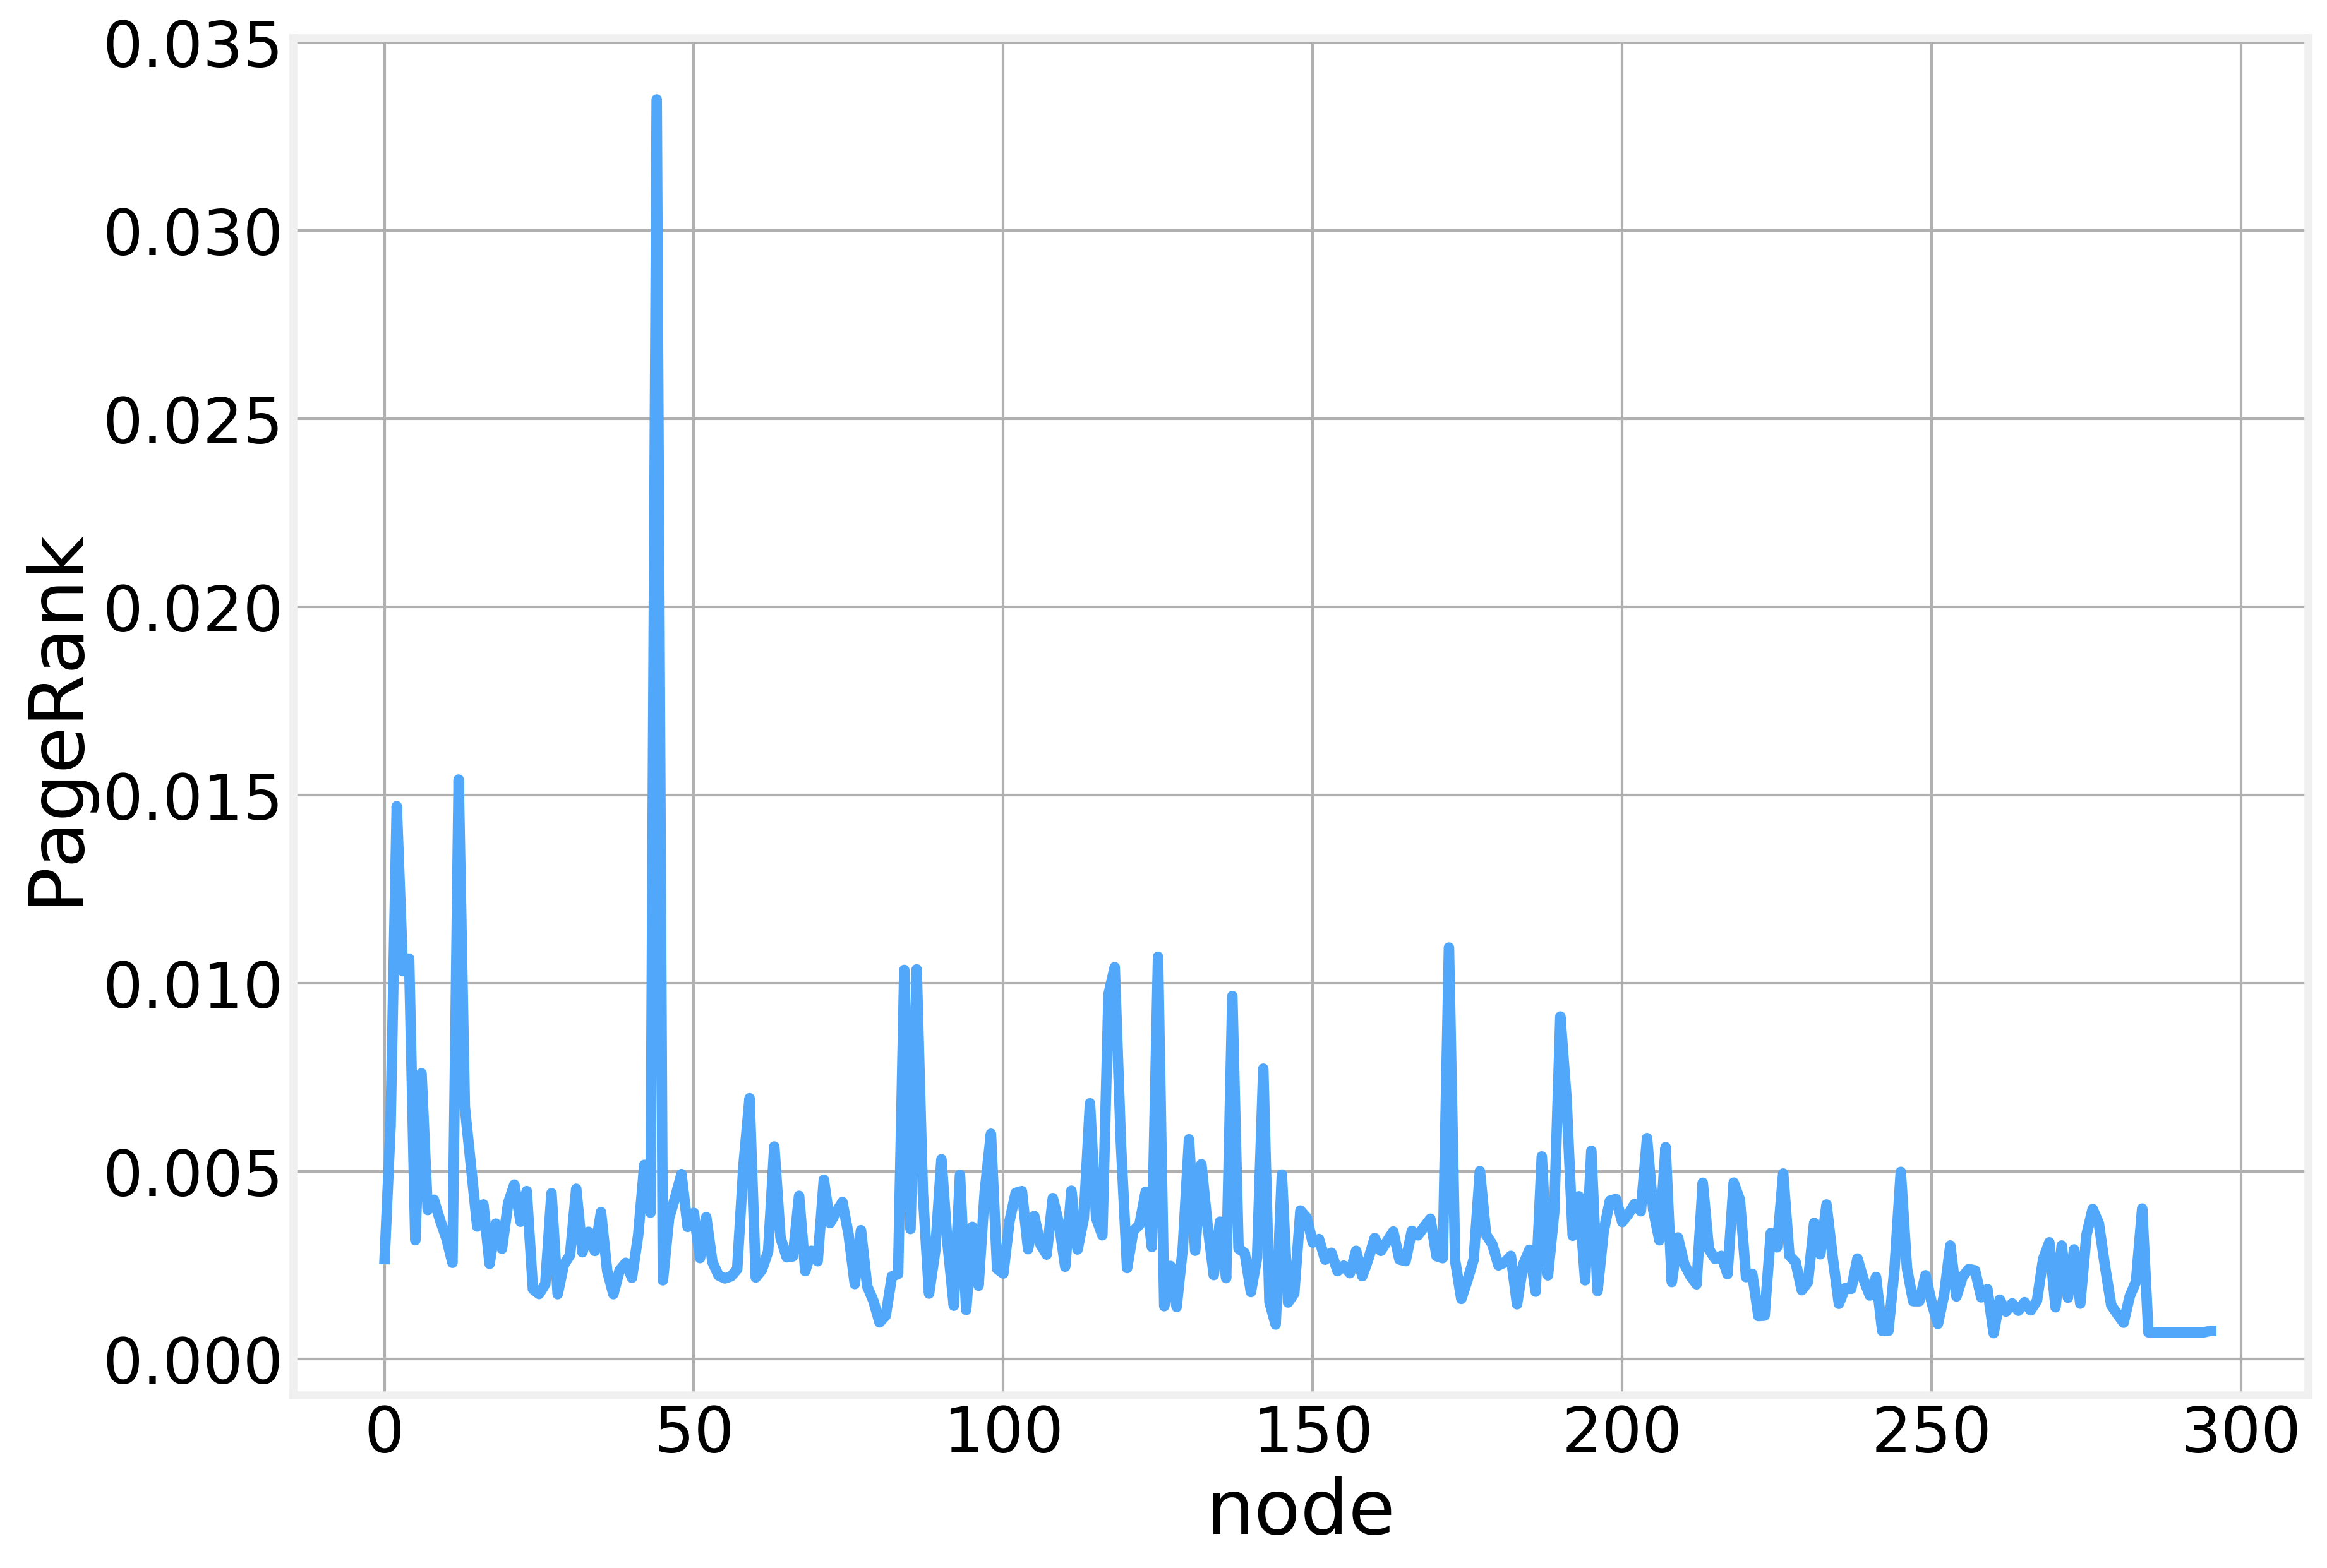

In [24]:
plt.plot(x0)
plt.xlabel('node')
plt.ylabel('PageRank')

As expected, some nodes have much higher values than others, corresponding to their mode central location in the network. However, PageRank is sensitive to not only local connections (degree) but also higher order relations so that it is not simply proportional to the degree of each node

Text(0, 0.5, 'PageRank')

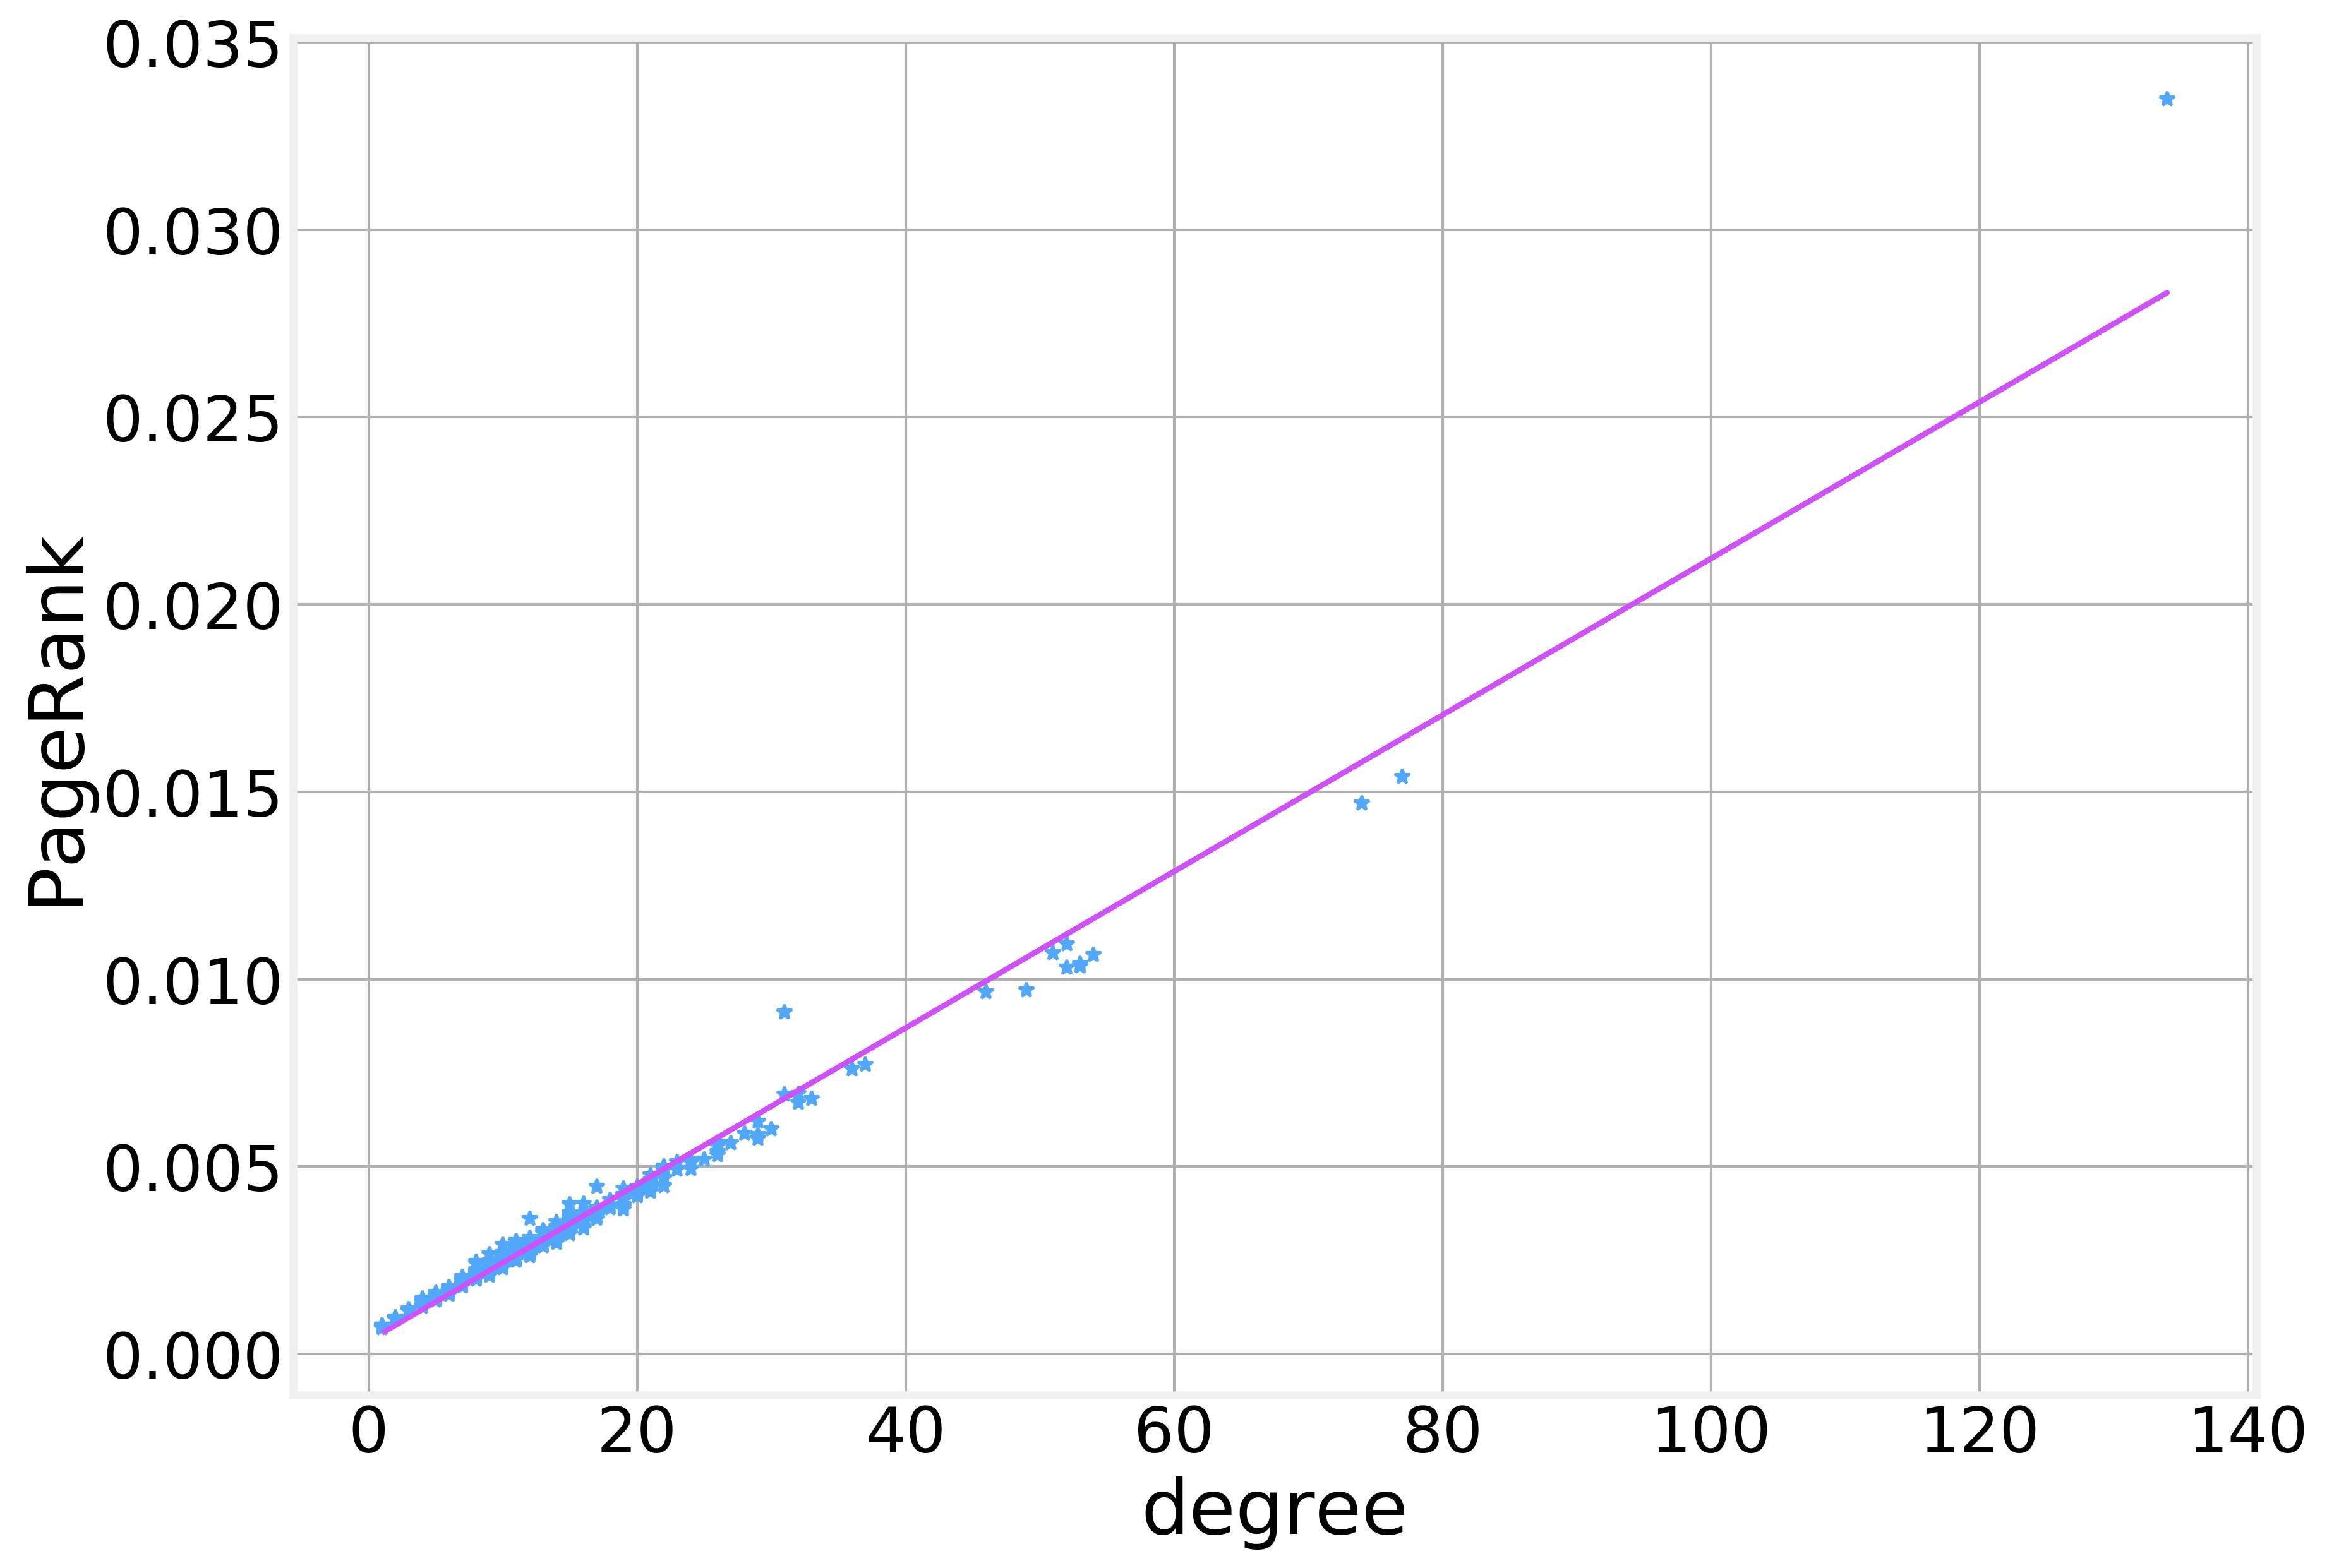

In [25]:
lm = LinearRegression()
lm.fit(K_i.reshape(-1, 1), x0.reshape(-1, 1))

plt.plot(K_i, x0, '*')
plt.plot(K_i, lm.predict(K_i.reshape(-1, 1)), '-', lw=2)
plt.xlabel('degree')
plt.ylabel('PageRank')

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>